# Tuning LoRA Hyperparameters - 

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-230810-1443'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-230810-1443 => Completed
Best parameters found: {'sst2-learning-rate': '0.0003979340903356249'}


{'sst2-learning-rate': 0.0003979340903356249}

### Vertical / Layers

According to our intuition shouldn't we see that modules closer to the task head have bigger impact on the performance after finetuning?

With finetuning we are adapting the modules in our neural network. The task we want to finetune on is usually something different than we pre-trained on, e.g. we finetune on `sentiment analysis` of emails, while we pre-trained on `next token` prediction.

In this scenario we would expect that the impact of changes close to the bottom of the network, where the inputs come in, are smaller than the changes a the top of the network. As the understanding of language (bottom) would not be as strongly impacted as what to do with it (top).

So let's put this to the test and only tune some layers from the bottom, from the top, and evenly spread out.



In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig
vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 5
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['12_upper', '12_lower', '12_even', 'all'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-vertical',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}


lora_vertical_tuner = HyperparameterTuner(**tuner_parameters)
lora_vertical_tuner.fit(wait=False)

Using provided s3_resource


### Horizontal / Modules

We just submitted some tuning jobs to gauge the vertical (by layer) impact, but what about the horizontal approach to explore the impact of the individual modules, e.g. the query vectors?

There are a lot of interactions between these modules. Hence it would be good to also experiment with the impact of combining these modules. But given the combinatorial explosion of possible trials we stick to validating each module individually, for now. Another important (over-)simplification is to keep in mind is the `r` parameter. The number of parameters of a query vector is very different from the up-projection of the feed-forward layer. But to get a first impression we keep `r` fixed. These are the modules we look into:

Attention:
- q - query
- k - key
- v - value
- o - output

Feed Forward:
- u - up projection, i.e. 768 -> 3072
- d - down projection, i.e. 3072 -> 768


In [7]:
horizontal_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q', 'att_k', 'att_v', 'att_o', 'ff_u', 'ff_d'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_estimator,
    base_tuning_job_name = 'lora-horizontal',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horizontal_tuner = HyperparameterTuner(**tuner_parameters)
lora_horizontal_tuner.fit(wait=False)

Using provided s3_resource


### Rank

The third angle we explore is chosing `r`. When increasing `r` slowly, at some point we must cross the threshold where `r` becomes higher than the rank of `lora_A` and `lora_B`. Increasing `r` above that level will only make the training more costly with no additional benefit for our model's performance. What is that threshold?

_Sidebar: As we use the Random Search strategy with SageMaker AMT and accordingly no learning is happening in between the trials, theoretically, we could run all trials of this tuning in parallel. Also, we could run this tuning job in parallel to the two tuning jobs before (vertical and horizontal exploration), but we would need to increase our account limit for the training instance types to more than 20, which we haven't. 
So instead, we wait for the other tuning jobs to finish:_

In [8]:
lora_vertical_tuner.wait()
lora_horizontal_tuner.wait()

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
.............................................................................................................................................!


In [9]:
lora_r_estimator = PyTorch(**get_default_estimator_parameters())
lora_r_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'sst2-lora-r': CategoricalParameter([2, 4, 8, 16, 32]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = lora_r_estimator,
    base_tuning_job_name = 'lora-r',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_r_tuner = HyperparameterTuner(**tuner_parameters)
lora_r_tuner.fit(wait=False)

Using provided s3_resource


### Analysis

#### Vertical

In [ ]:
display_tuning_jobs(lora_vertical_tuner)

'lora-vertical-230810-2220'

The vertical exploration was insightful, but not at all what I expected. 

We have a 12 layers model and compared these four configurations:

- __all__: We finetuned all 12 layers using LoRA. This is just for comparison and has double the amount of parameters than the other combinations.
- __lower__: We only finetuned adapters for the 6 lowest layers, closest to the inputs.
- __upper__: We only finetuned adapters for the 6 top layers, closest to the task.
- __even__: We only finetuned adapters for 6 layers, evenly spread out over. 

For our task `sentiment analysis` it appeared reasonable to me that a lot of the interpretation of the inputs could be close to the task head, and is not so much dependent on individual words being meaningful on their own. If that were the case then __upper__ should have outperformed __lower__. __Even__ was the best scenario. But even this scenario was not able to outperform __all__ with double the amount of parameters. 

If you feel inclined, and you ran this notebook for yourself, interact with it. You can select the scenario that is interesting to you and see how the results change. One notable find is that when selecting __upper__ the GPU memory utilization (`gpu_memory`) goes down from 80+% to 55%. Likely because the gradients then only have to be calculated for a relatively short path, just for the classifier and the upper layers. 

Also checkout how the training velocity (`train_samples_sec`).

'lora-horizontal-230810-2221'

!
Tuning job lora-horizontal-230810-2221 status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.9082568883895874 Highest 0.9461008906364441


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
8       1             ff_u  lora-horizontal-230810-2221-022-f194580f         Completed 2023-08-10 22:52:33+02:00 2023-08-10 23:09:33+02:00                      1020.0  lora-horizontal-230810-2221        0.946101
6       3             ff_u  lora-horizontal-230810-2221-024-ba0a2eda         Completed 2023-08-10 22:55:27+02:00 2023-08-10 23:10:12+02:00                       885.0  lora-horizontal-230810-2221        0.944954
9       0             ff_u  lora-horizontal-230810-2221-021-23372269         Completed 2023-08-10 22:52:31+02:00 2023-08-10 23:07:20+02:00                       889.0  lora-horizontal-230810-2221        0.943807
7       2             ff_u  lora-horizontal-230810-2221-023-2f4ec73c         Completed 2023-08-10 22:55:04+02:00 2023-08-10 23:09:58+02:00                       894.0  lora-horizontal-230810-2221        0.942661
2       2             ff_d  lora-horizontal-230810-2221-028-51ba5991         Completed 2023-08-10 22:56:05+02:00 2023-08-10 23:10:52+02:00                       887.0  lora-horizontal-230810-2221        0.934633
1       3             ff_d  lora-horizontal-230810-2221-029-ea3c2cbc         Completed 2023-08-10 22:56:12+02:00 2023-08-10 23:10:54+02:00                       882.0  lora-horizontal-230810-2221        0.934633
18      1            att_v  lora-horizontal-230810-2221-012-f12d8b90         Completed 2023-08-10 22:37:43+02:00 2023-08-10 22:53:32+02:00                       949.0  lora-horizontal-230810-2221        0.933486
4       0             ff_d  lora-horizontal-230810-2221-026-58056d02         Completed 2023-08-10 22:55:49+02:00 2023-08-10 23:10:37+02:00                       888.0  lora-horizontal-230810-2221        0.933486
0       4             ff_d  lora-horizontal-230810-2221-030-e3a7a939         Completed 2023-08-10 22:56:20+02:00 2023-08-10 23:11:14+02:00                       894.0  lora-horizontal-230810-2221        0.932339
14      0            att_o  lora-horizontal-230810-2221-016-bf14bb16         Completed 2023-08-10 22:40:16+02:00 2023-08-10 22:54:56+02:00                       880.0  lora-horizontal-230810-2221        0.931193

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


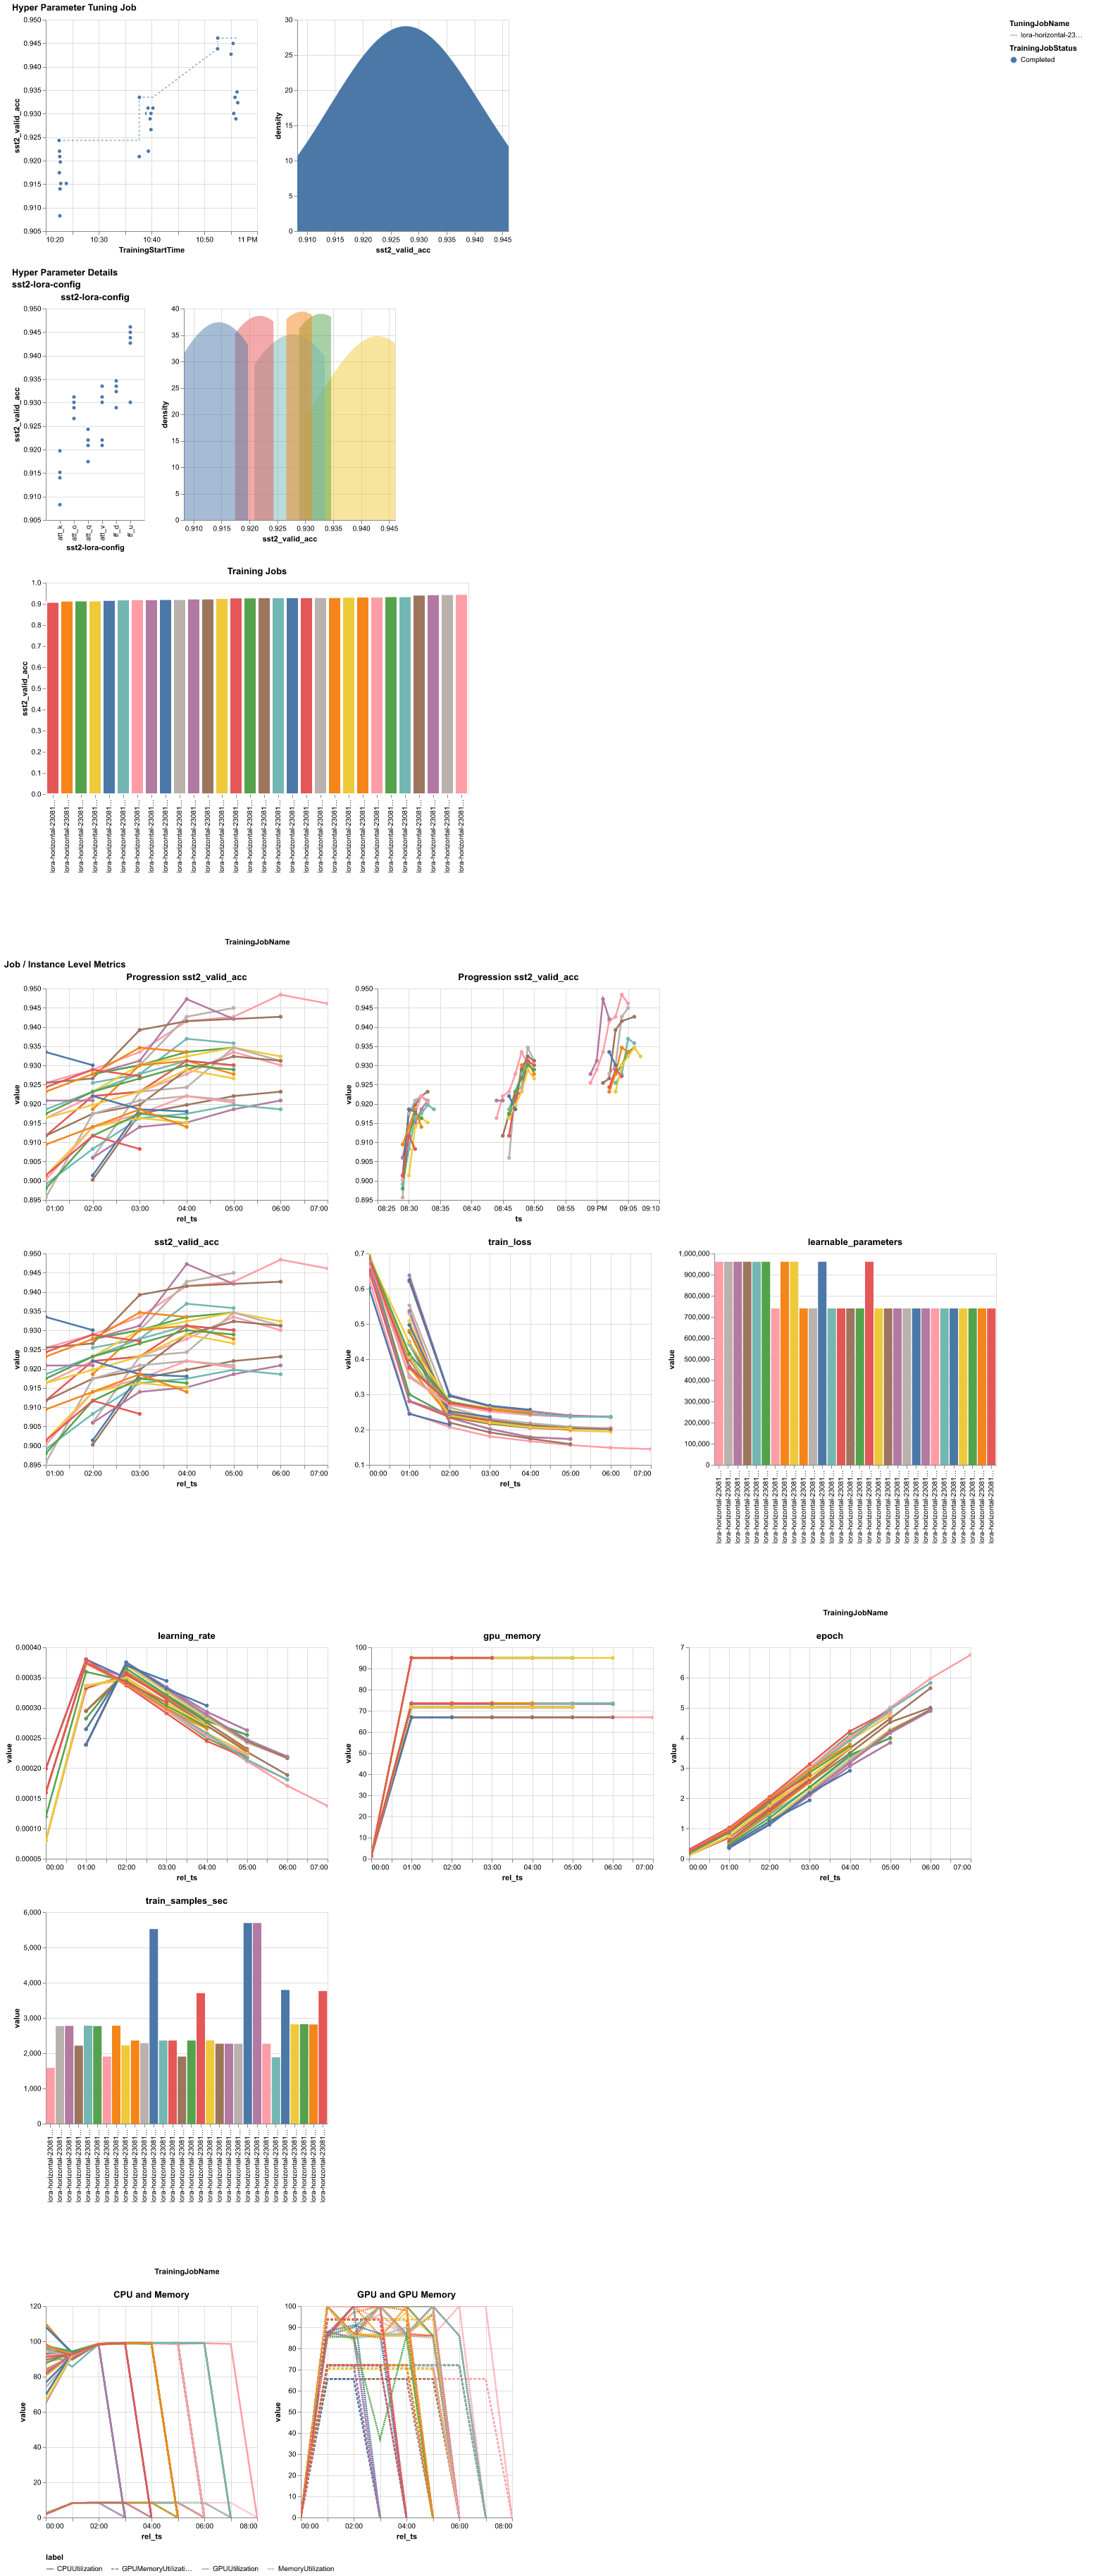

In [42]:
display_tuning_jobs(lora_horizontal_tuner)

#### Horizontal

The __horizontal__ was great. FIXME

Reviewing different values of `r` was different to what we hoped for. We saw with a larger `r` that we also got more variance. This was likely a sign of overfitting then. FIXME. This is also supported by the high variance on the `valid_loss` as you can see above. 

Also, we saw that bla bla, so let's try horizonatal combinations bla bla

'lora-r-230810-2312'

!
Tuning job lora-r-230810-2312        status: Completed

Number of training jobs with valid objective: 35
Lowest: 0.9311926364898682 Highest 0.9541284441947937


dummy  sst2-lora-r                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
1       6           16  lora-r-230810-2312-034-d04a30db         Completed 2023-08-11 00:07:44+02:00 2023-08-11 00:26:19+02:00                      1115.0  lora-r-230810-2312        0.954128
5       5           32  lora-r-230810-2312-030-b04d4ac2         Completed 2023-08-10 23:54:51+02:00 2023-08-11 00:12:03+02:00                      1032.0  lora-r-230810-2312        0.950688
27      1            8  lora-r-230810-2312-008-1d8ad4c0         Completed 2023-08-10 23:14:23+02:00 2023-08-10 23:33:00+02:00                      1117.0  lora-r-230810-2312        0.949541
16      3           16  lora-r-230810-2312-019-bda4386c         Completed 2023-08-10 23:34:15+02:00 2023-08-10 23:51:24+02:00                      1029.0  lora-r-230810-2312        0.949541
22      2            8  lora-r-230810-2312-013-3d8d8fb8         Completed 2023-08-10 23:32:09+02:00 2023-08-10 23:49:19+02:00                      1030.0  lora-r-230810-2312        0.949541
17      3            8  lora-r-230810-2312-018-8cbbb614         Completed 2023-08-10 23:34:00+02:00 2023-08-10 23:51:10+02:00                      1030.0  lora-r-230810-2312        0.948394
19      3            2  lora-r-230810-2312-016-75c8e14e         Completed 2023-08-10 23:32:45+02:00 2023-08-10 23:53:31+02:00                      1246.0  lora-r-230810-2312        0.948394
6       5           16  lora-r-230810-2312-029-f5651a58         Completed 2023-08-10 23:52:38+02:00 2023-08-11 00:09:53+02:00                      1035.0  lora-r-230810-2312        0.948394
29      1            2  lora-r-230810-2312-006-a25da9fe         Completed 2023-08-10 23:14:20+02:00 2023-08-10 23:32:55+02:00                      1115.0  lora-r-230810-2312        0.947248
20      2           32  lora-r-230810-2312-015-6bfc86f2         Completed 2023-08-10 23:32:40+02:00 2023-08-10 23:48:24+02:00                       944.0  lora-r-230810-2312        0.947248

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


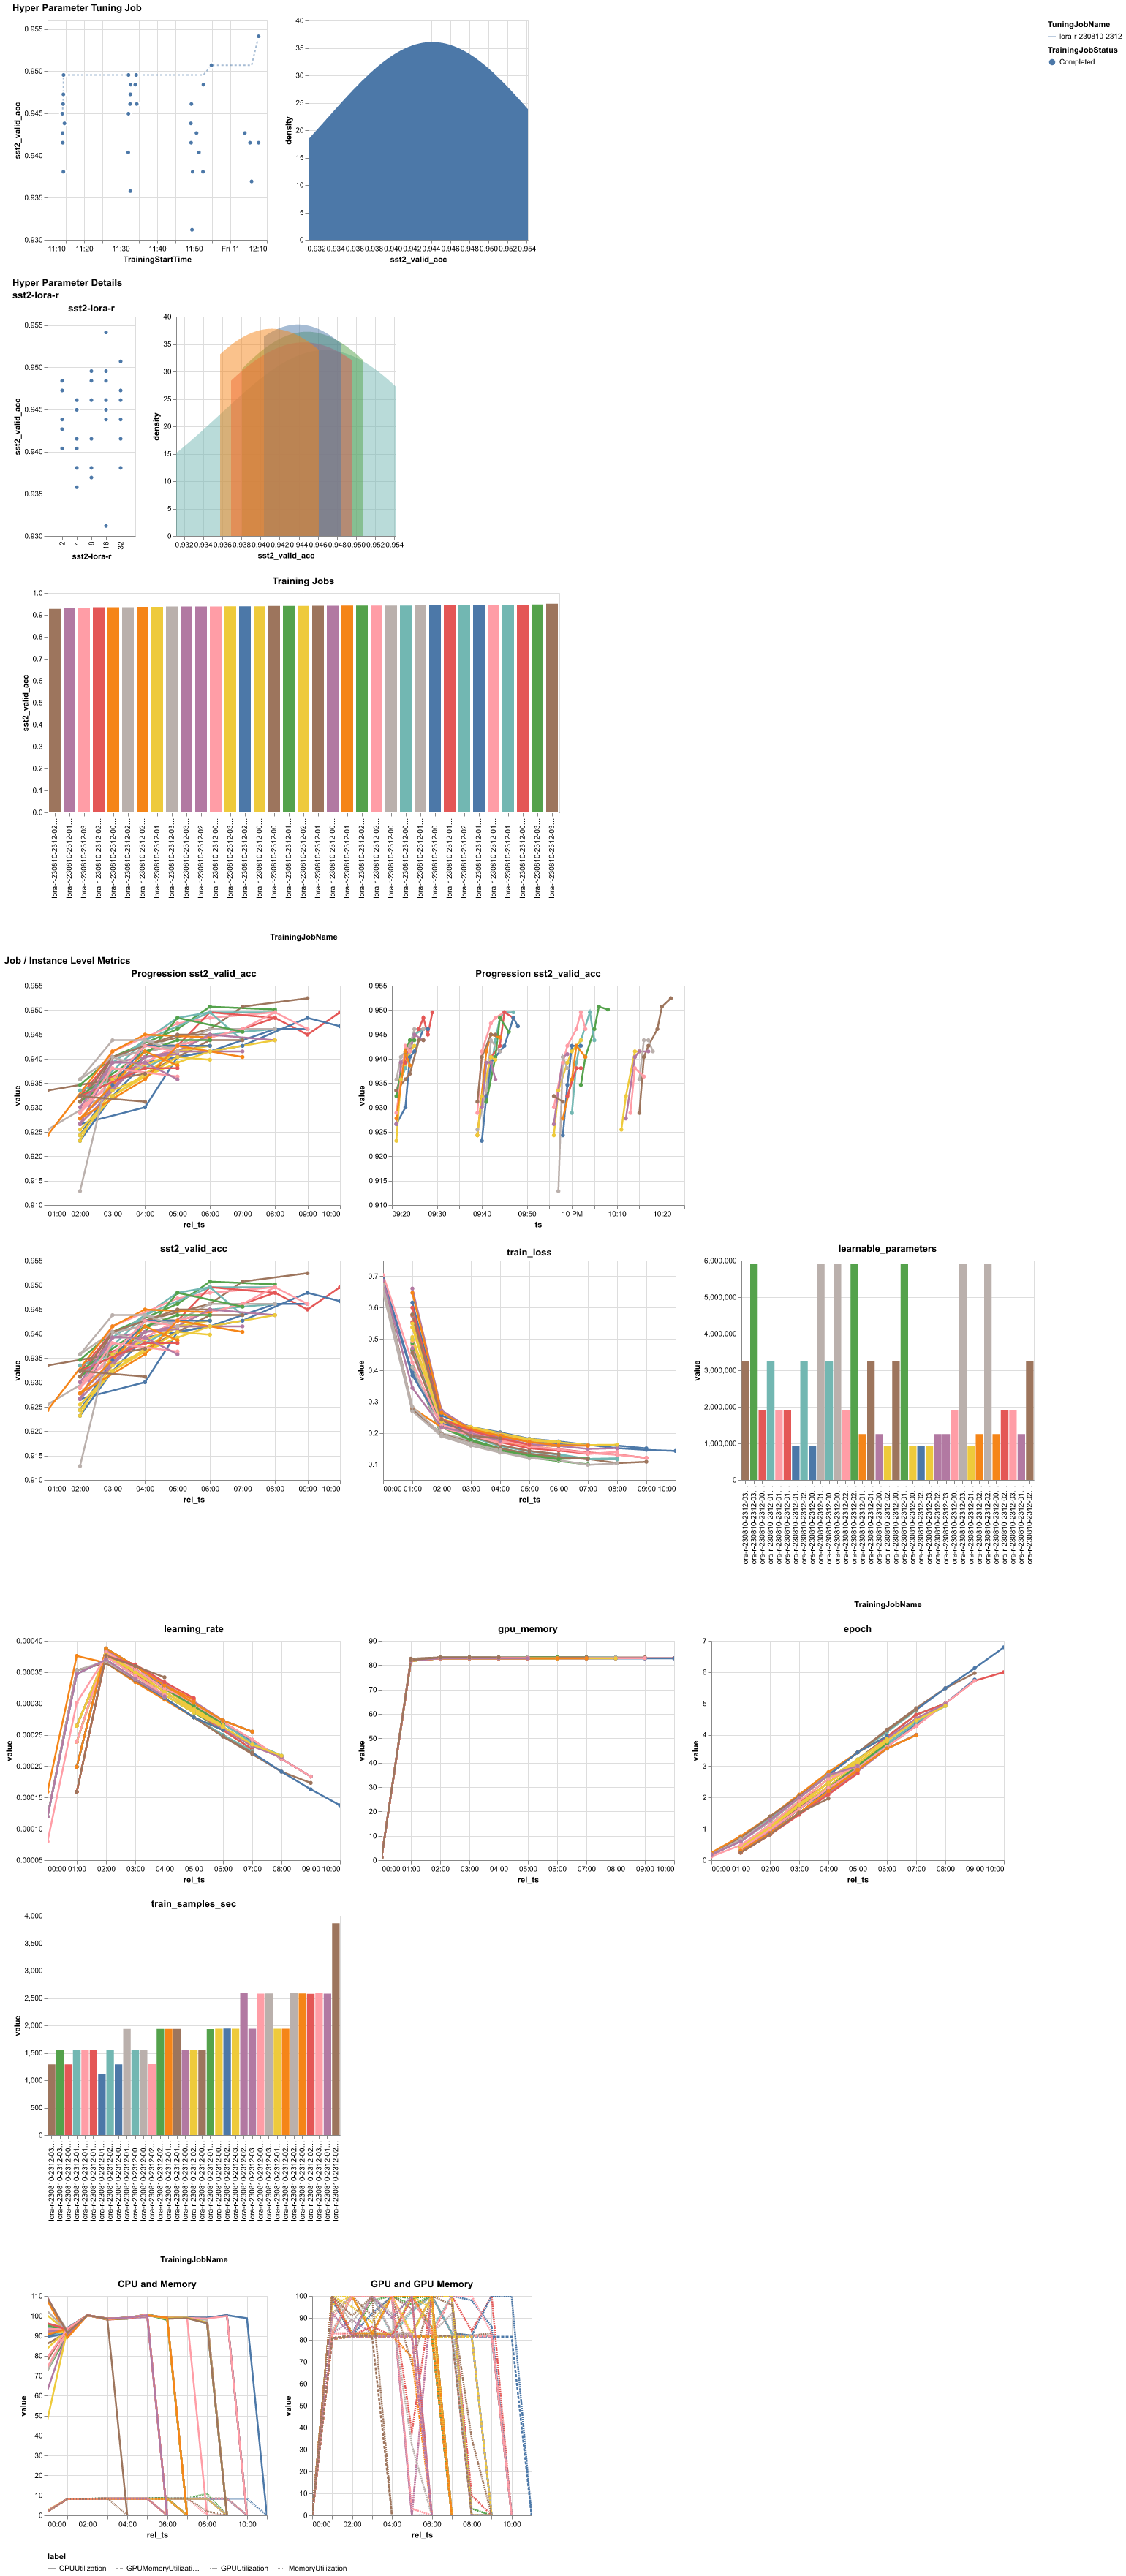

In [41]:
display_tuning_jobs(lora_r_tuner)

#### R

...

### Horizontal Combinations

In [15]:
horizontal_comb_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_comb_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 3
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q+ff_u','ff_d+ff_u','att_k+ff_u','att_v+ff_u','att_o+ff_u', 'att_qk+ff_u','att_qv+ff_u']) 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_comb_estimator,
    base_tuning_job_name = 'lora-horiz-comb',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horiz_comb_tuner = HyperparameterTuner(**tuner_parameters)
lora_horiz_comb_tuner.fit(wait=False)

Using provided s3_resource


'lora-horiz-comb-230811-0908'

!
Tuning job lora-horiz-comb-230811-0908 status: Completed

Number of training jobs with valid objective: 21
Lowest: 0.9300458431243896 Highest 0.9541284441947937


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
10      1       att_v+ff_u  lora-horiz-comb-230811-0908-011-d87d0277         Completed 2023-08-11 09:24:54+02:00 2023-08-11 09:40:18+02:00                       924.0  lora-horiz-comb-230811-0908        0.954128
9       2       att_v+ff_u  lora-horiz-comb-230811-0908-012-f1047211         Completed 2023-08-11 09:25:41+02:00 2023-08-11 09:41:16+02:00                       935.0  lora-horiz-comb-230811-0908        0.954128
11      0       att_v+ff_u  lora-horiz-comb-230811-0908-010-5084bae4         Completed 2023-08-11 09:09:59+02:00 2023-08-11 09:25:24+02:00                       925.0  lora-horiz-comb-230811-0908        0.951835
20      0       att_q+ff_u  lora-horiz-comb-230811-0908-001-77854509         Completed 2023-08-11 09:09:49+02:00 2023-08-11 09:25:19+02:00                       930.0  lora-horiz-comb-230811-0908        0.951835
19      1       att_q+ff_u  lora-horiz-comb-230811-0908-002-197db9c5         Completed 2023-08-11 09:10:44+02:00 2023-08-11 09:26:02+02:00                       918.0  lora-horiz-comb-230811-0908        0.950688
16      1        ff_d+ff_u  lora-horiz-comb-230811-0908-005-3a800063         Completed 2023-08-11 09:09:46+02:00 2023-08-11 09:25:36+02:00                       950.0  lora-horiz-comb-230811-0908        0.950688
15      2        ff_d+ff_u  lora-horiz-comb-230811-0908-006-73bdbd95         Completed 2023-08-11 09:09:53+02:00 2023-08-11 09:25:30+02:00                       937.0  lora-horiz-comb-230811-0908        0.948394
13      1       att_k+ff_u  lora-horiz-comb-230811-0908-008-59f04323         Completed 2023-08-11 09:09:57+02:00 2023-08-11 09:25:16+02:00                       919.0  lora-horiz-comb-230811-0908        0.947248
12      2       att_k+ff_u  lora-horiz-comb-230811-0908-009-58d78f2d         Completed 2023-08-11 09:09:56+02:00 2023-08-11 09:25:40+02:00                       944.0  lora-horiz-comb-230811-0908        0.946101
1       1      att_qv+ff_u  lora-horiz-comb-230811-0908-020-ea937371         Completed 2023-08-11 09:27:27+02:00 2023-08-11 09:42:16+02:00                       889.0  lora-horiz-comb-230811-0908        0.942661

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


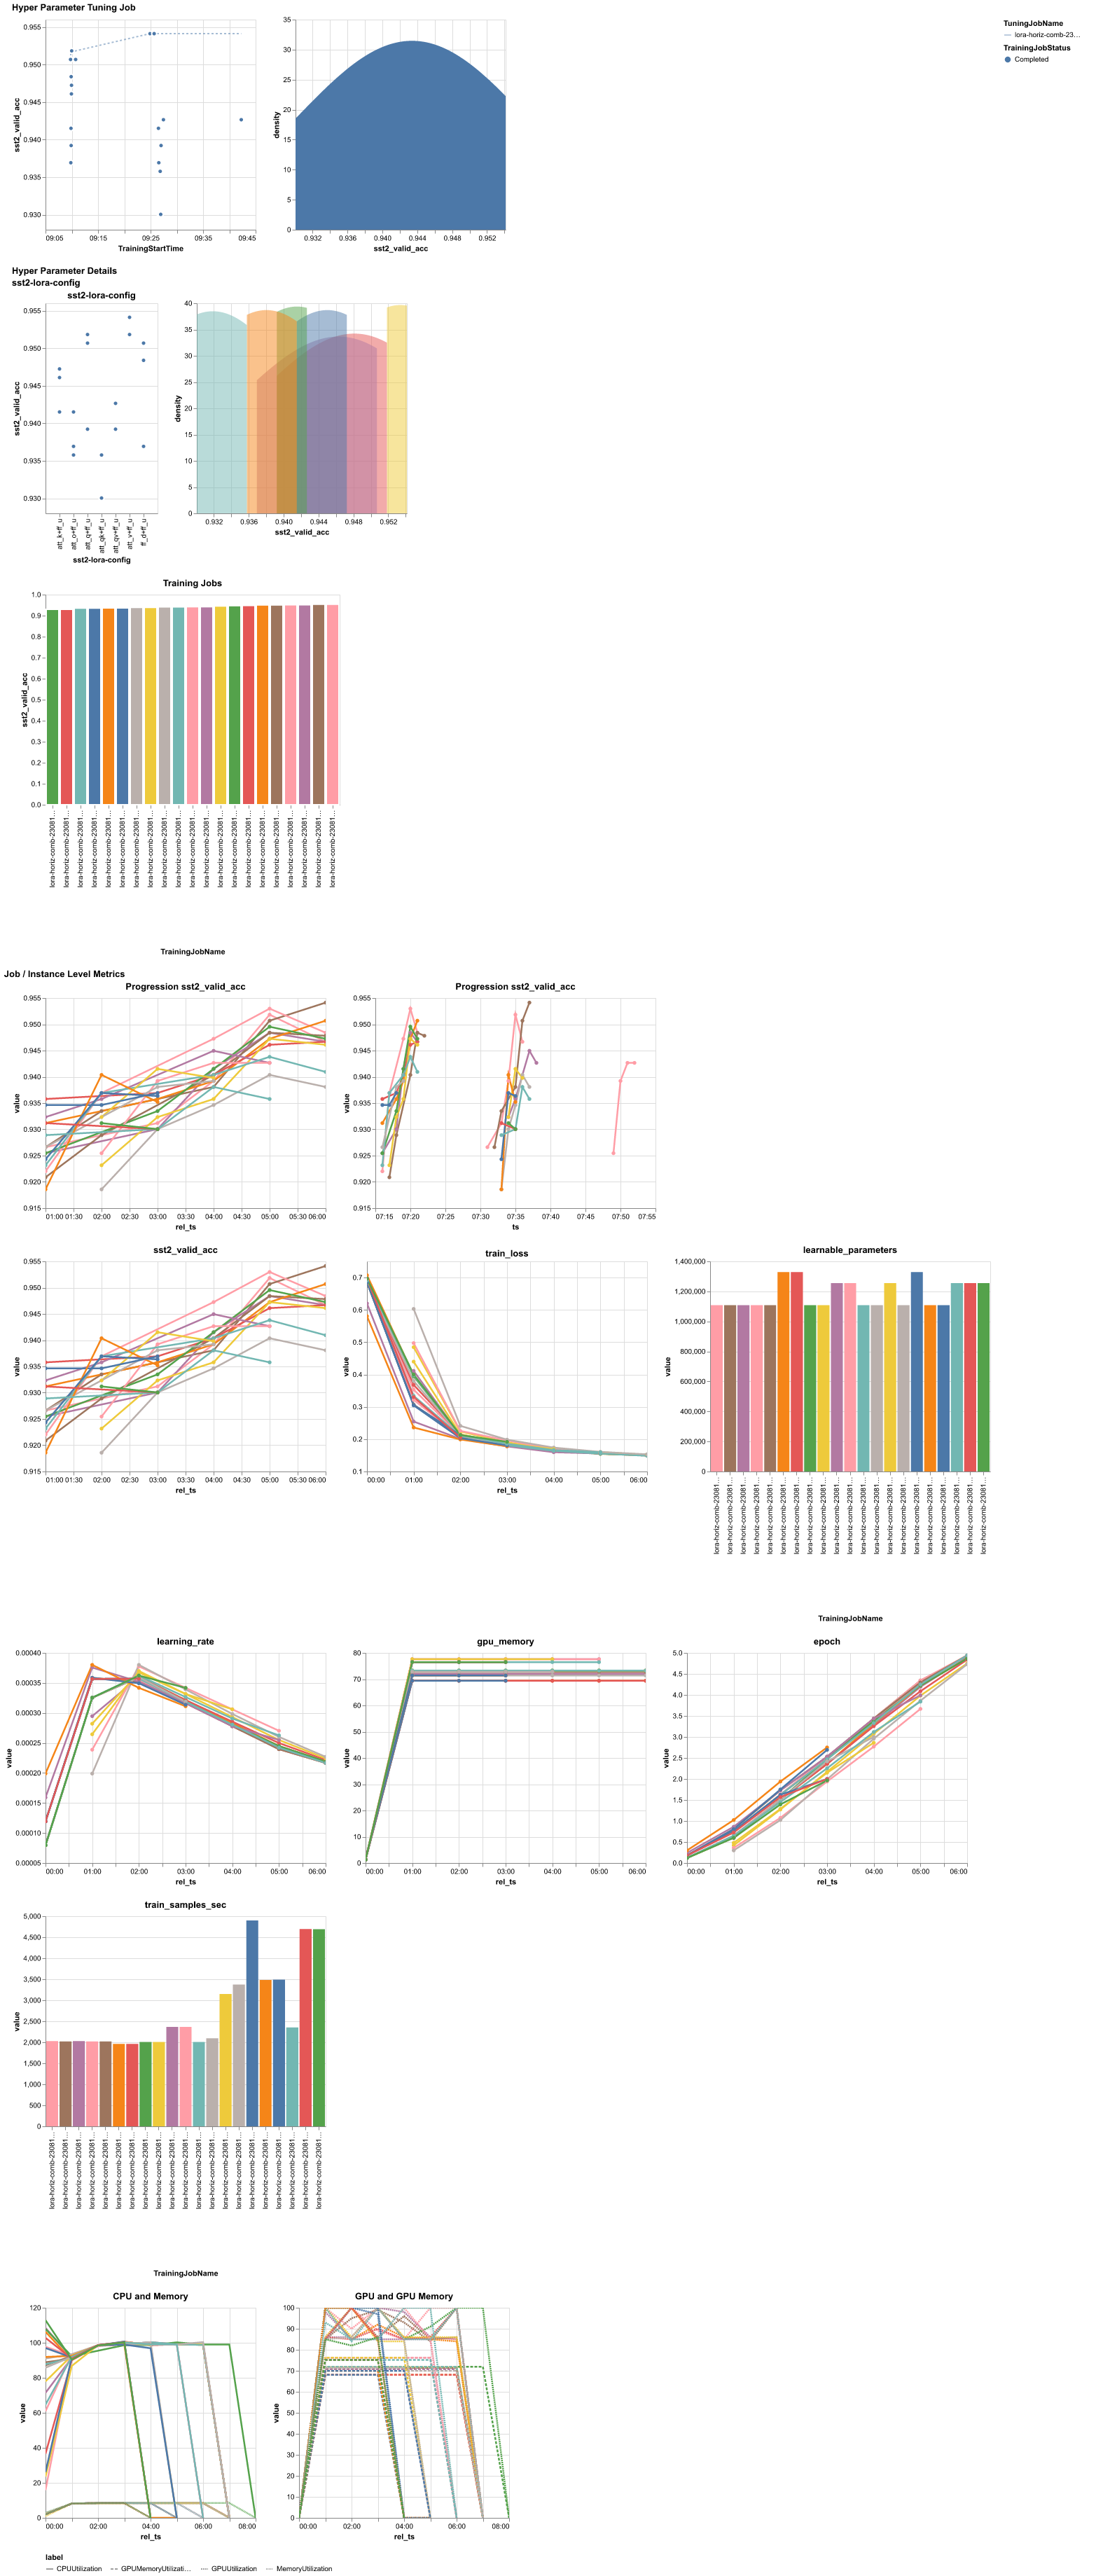

In [40]:
display_tuning_jobs(lora_horiz_comb_tuner)

### Another Shot At Tuning Rank

It looks like not only should we tune learning rate for higher `r`, but given that this creates a higher capacity network, we should also re-consider regularization. 

Unfortunately this means we need to have a few more trials to find out. To keep this mangeable, let's start with just a few discrete experiments instead of a large sweep over the solution space as we did with only tuning `r` above.

Let's say we know that `r=8` works well and we want to test `r=16`. The latter should not show a decline in performance, but either be the same or better; if tuned correctly. 

If we see no change it may mean that we have found the point of saturation, where more capacity is not helping anymore as we are above the true rank. We may do another experiment with `r==4` then to find an approximation of the true `r`.

If the performance improves, we should also run another experiment, to verify where we find the point of saturation.

In [17]:
from sagemaker.tuner import ContinuousParameter

horizontal_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})
n_trials = 6

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(best_hyperparameters['sst2-learning-rate']* 0.95, best_hyperparameters['sst2-learning-rate']*1.05),
}

In [18]:
r_tuning_jobs = []
for r in [2, 4, 8, 16, 32]:
    estimator = PyTorch(**get_default_estimator_parameters())
    estimator.set_hyperparameters(**{'sst2-lora-config': 'all', 'sst2-lora-r': r, **best_hyperparameters})
    
    tuner_parameters = {**(p('tuner_parameters') | dict(
        strategy='Bayesian',
        hyperparameter_ranges=hpt_ranges,
        metric_definitions=p('metric_definitions'),
        estimator = estimator,
        base_tuning_job_name = f'r{r:02d}-warm',
        max_jobs = n_trials,
        max_parallel_jobs = 1,
    ))}
    
    tuner = HyperparameterTuner(**tuner_parameters)
    tuner.fit(wait=False)
    r_tuning_jobs.append((r, tuner))

Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource


In [20]:
for j in r_tuning_jobs:
    print(j[-1].describe()['HyperParameterTuningJobName'])
    j[-1].wait()

r02-warm-230811-0959
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
r04-warm-230811-0959
!
r08-warm-230811-0959
!
r16-warm-230811-0959
!
r32-warm-230811-0959
!


Tuning job r32-warm-230811-0959      status: Completed
Tuning job r04-warm-230811-0959      status: Completed
Tuning job r02-warm-230811-0959      status: Completed
Tuning job r08-warm-230811-0959      status: Completed
Tuning job r16-warm-230811-0959      status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.9380733966827393 Highest 0.9495412707328796


sst2-learning-rate                    TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds         TuningJobName  sst2_valid_acc
2            0.000411  r32-warm-230811-0959-004-cae6213c         Completed 2023-08-11 11:11:59+02:00 2023-08-11 11:29:10+02:00                      1031.0  r32-warm-230811-0959        0.949541
5            0.000402  r02-warm-230811-0959-001-83f85367         Completed 2023-08-11 10:00:23+02:00 2023-08-11 10:31:10+02:00                      1847.0  r02-warm-230811-0959        0.949541
4            0.000416  r08-warm-230811-0959-002-455d038d         Completed 2023-08-11 10:21:14+02:00 2023-08-11 10:38:19+02:00                      1025.0  r08-warm-230811-0959        0.949541
2            0.000384  r02-warm-230811-0959-004-c69d7510         Completed 2023-08-11 11:16:50+02:00 2023-08-11 11:37:36+02:00                      1246.0  r02-warm-230811-0959        0.949541
3            0.000414  r32-warm-230811-0959-003-deed7c38         Completed 2023-08-11 10:47:25+02:00 2023-08-11 11:08:11+02:00                      1246.0  r32-warm-230811-0959        0.948394
3            0.000412  r08-warm-230811-0959-003-9c2befff         Completed 2023-08-11 10:41:53+02:00 2023-08-11 10:58:57+02:00                      1024.0  r08-warm-230811-0959        0.948394
3            0.000389  r16-warm-230811-0959-003-8ea0403a         Completed 2023-08-11 10:42:42+02:00 2023-08-11 10:59:47+02:00                      1025.0  r16-warm-230811-0959        0.947248
5            0.000389  r08-warm-230811-0959-001-c64f0528         Completed 2023-08-11 10:00:30+02:00 2023-08-11 10:18:56+02:00                      1106.0  r08-warm-230811-0959        0.947248
5            0.000400  r04-warm-230811-0959-001-8efddcd8         Completed 2023-08-11 10:00:26+02:00 2023-08-11 10:17:46+02:00                      1040.0  r04-warm-230811-0959        0.947248
0            0.000394  r08-warm-230811-0959-006-d623fc3e         Completed 2023-08-11 11:37:21+02:00 2023-08-11 11:54:37+02:00                      1036.0  r08-warm-230811-0959        0.946101

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


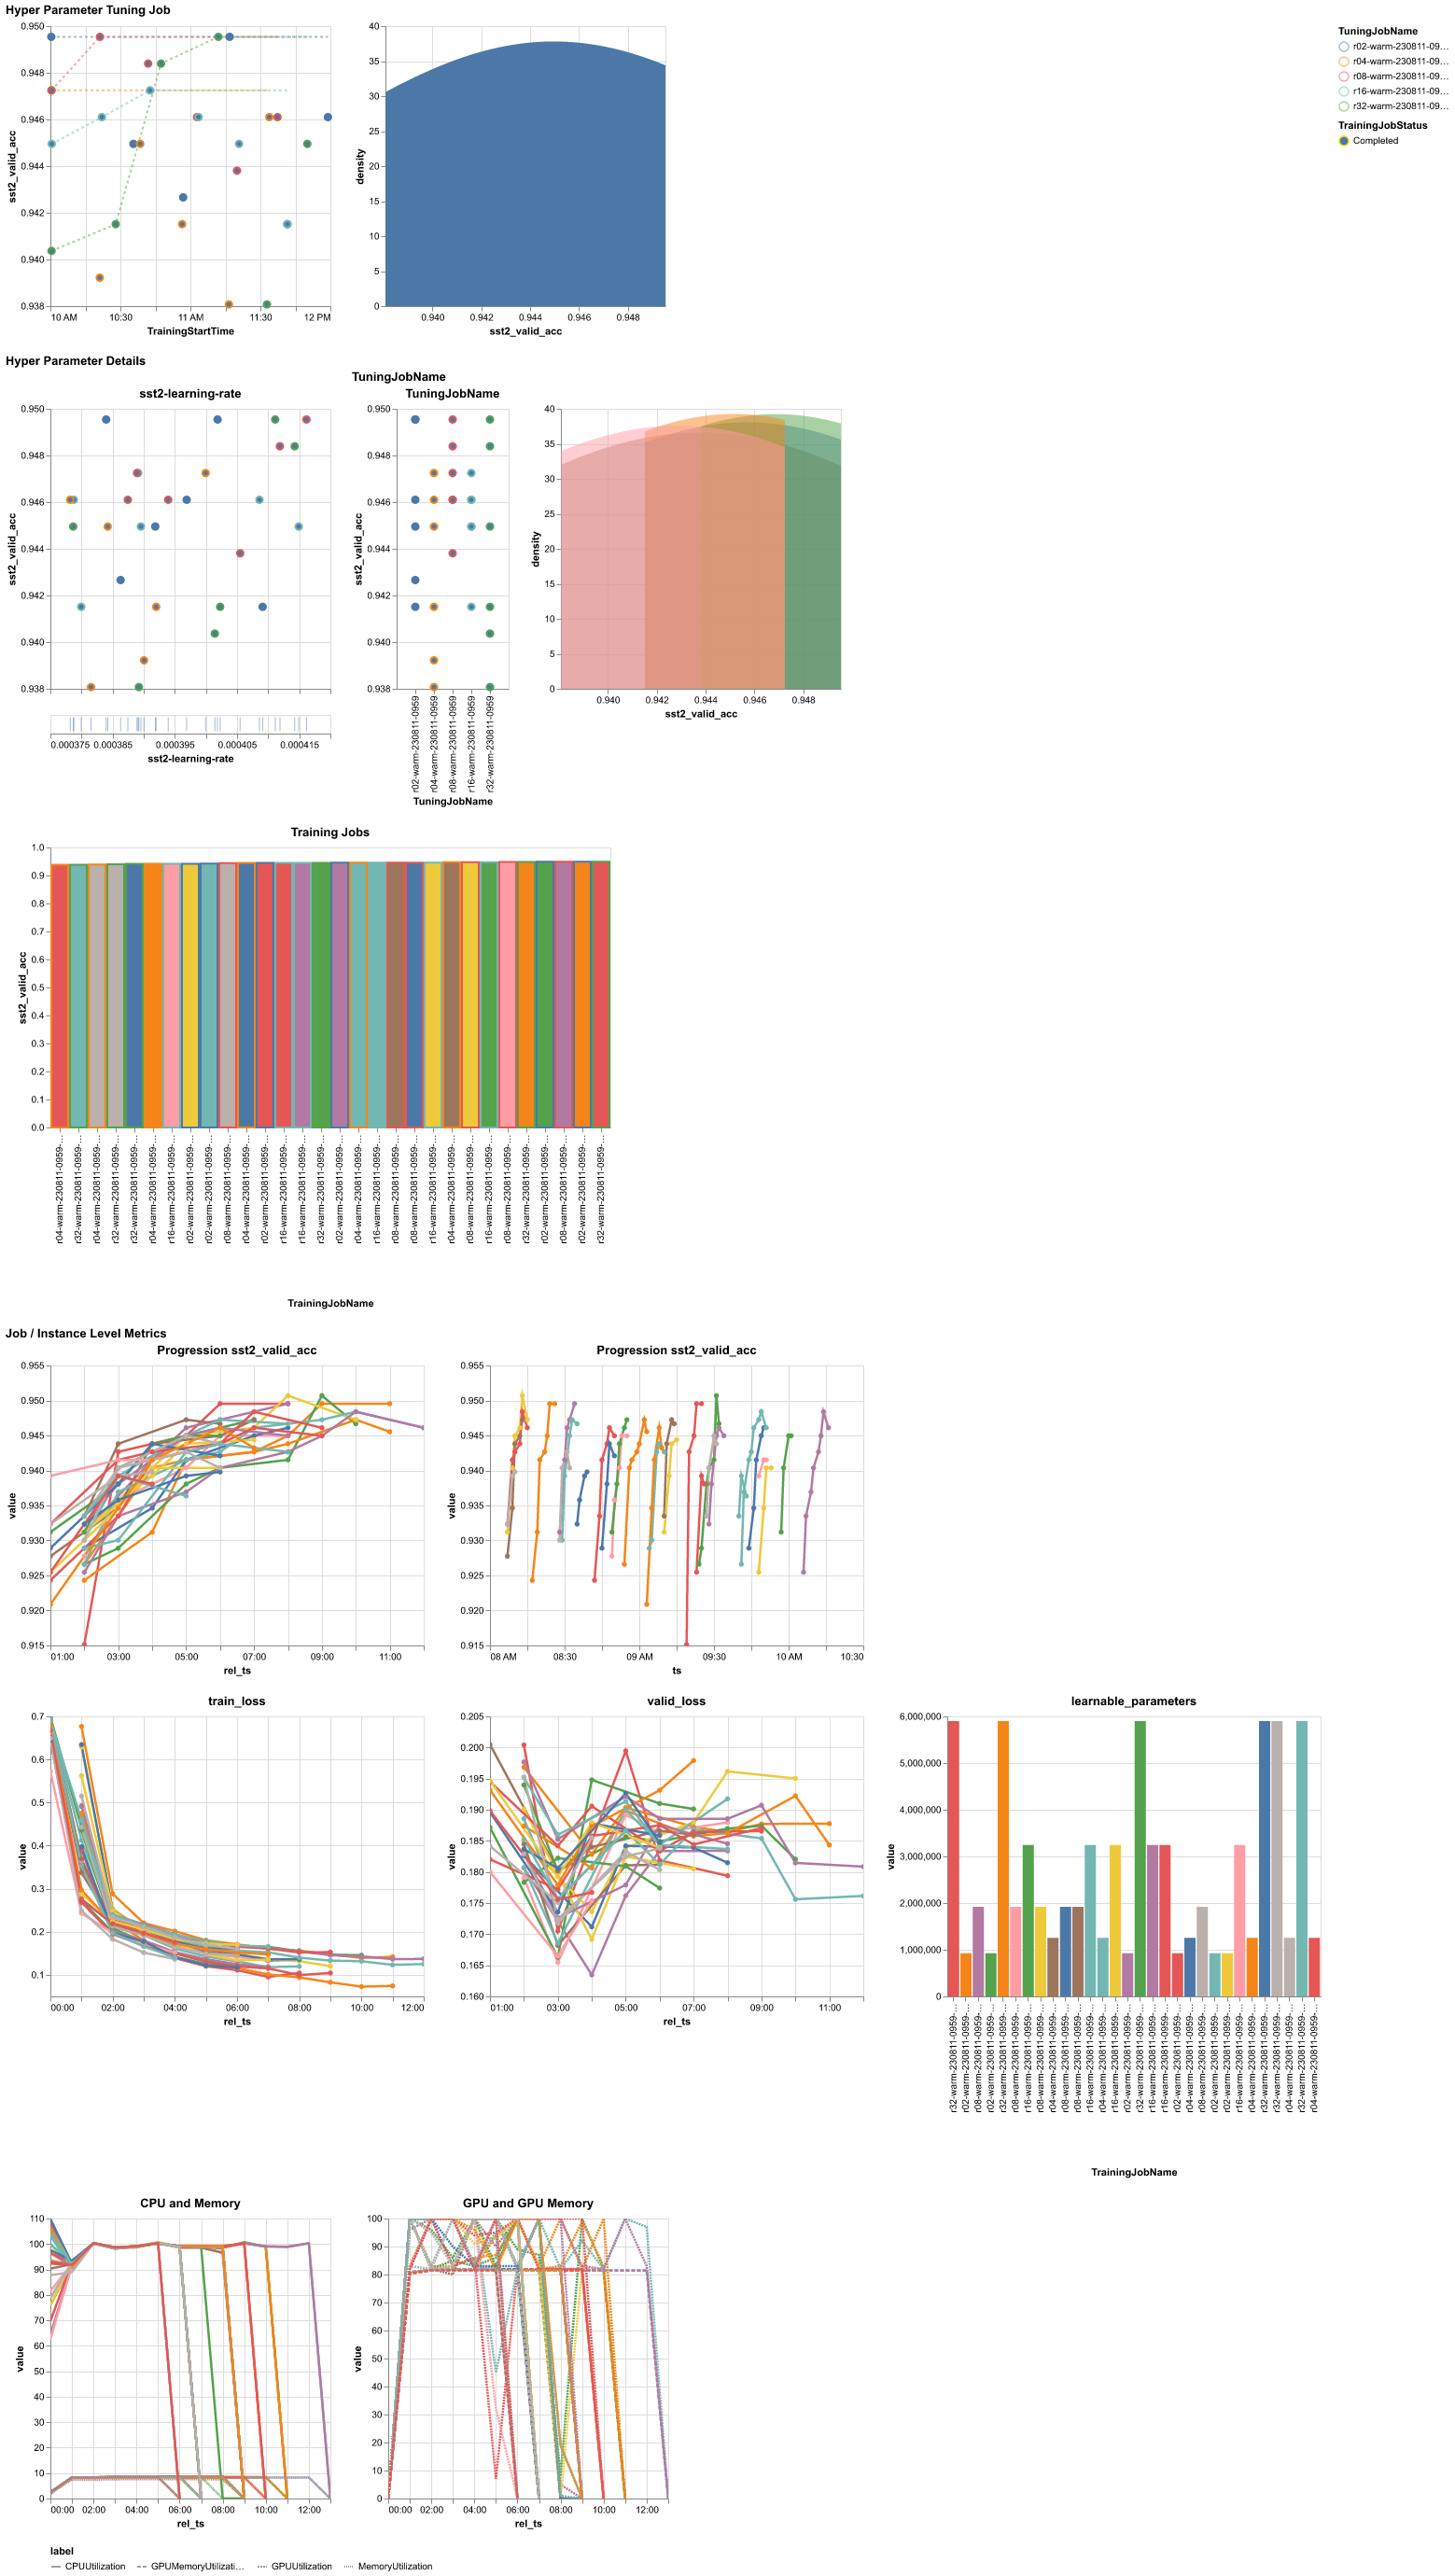

In [39]:
visualize_tuning_job([j[1] for j in r_tuning_jobs], job_metrics=['train_loss', 'valid_loss', 'learnable_parameters'], advanced=True)

In [37]:
chart, trials_df, full_df = visualize_tuning_job([tj for _, tj in r_tuning_jobs], advanced=True, return_dfs=True, trials_only=False, job_metrics=['train_loss', 'valid_loss', 'learnable_parameters' ,'eval_runtime', 'gpu_memory']); 

Tuning job r32-warm-230811-0959      status: Completed
Tuning job r04-warm-230811-0959      status: Completed
Tuning job r02-warm-230811-0959      status: Completed
Tuning job r08-warm-230811-0959      status: Completed
Tuning job r16-warm-230811-0959      status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.9380733966827393 Highest 0.9495412707328796


sst2-learning-rate                    TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds         TuningJobName  sst2_valid_acc
2            0.000411  r32-warm-230811-0959-004-cae6213c         Completed 2023-08-11 11:11:59+02:00 2023-08-11 11:29:10+02:00                      1031.0  r32-warm-230811-0959        0.949541
5            0.000402  r02-warm-230811-0959-001-83f85367         Completed 2023-08-11 10:00:23+02:00 2023-08-11 10:31:10+02:00                      1847.0  r02-warm-230811-0959        0.949541
4            0.000416  r08-warm-230811-0959-002-455d038d         Completed 2023-08-11 10:21:14+02:00 2023-08-11 10:38:19+02:00                      1025.0  r08-warm-230811-0959        0.949541
2            0.000384  r02-warm-230811-0959-004-c69d7510         Completed 2023-08-11 11:16:50+02:00 2023-08-11 11:37:36+02:00                      1246.0  r02-warm-230811-0959        0.949541
3            0.000414  r32-warm-230811-0959-003-deed7c38         Completed 2023-08-11 10:47:25+02:00 2023-08-11 11:08:11+02:00                      1246.0  r32-warm-230811-0959        0.948394
3            0.000412  r08-warm-230811-0959-003-9c2befff         Completed 2023-08-11 10:41:53+02:00 2023-08-11 10:58:57+02:00                      1024.0  r08-warm-230811-0959        0.948394
3            0.000389  r16-warm-230811-0959-003-8ea0403a         Completed 2023-08-11 10:42:42+02:00 2023-08-11 10:59:47+02:00                      1025.0  r16-warm-230811-0959        0.947248
5            0.000389  r08-warm-230811-0959-001-c64f0528         Completed 2023-08-11 10:00:30+02:00 2023-08-11 10:18:56+02:00                      1106.0  r08-warm-230811-0959        0.947248
5            0.000400  r04-warm-230811-0959-001-8efddcd8         Completed 2023-08-11 10:00:26+02:00 2023-08-11 10:17:46+02:00                      1040.0  r04-warm-230811-0959        0.947248
0            0.000394  r08-warm-230811-0959-006-d623fc3e         Completed 2023-08-11 11:37:21+02:00 2023-08-11 11:54:37+02:00                      1036.0  r08-warm-230811-0959        0.946101

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


In [38]:
full_df = full_df[full_df['TuningJobName'].str.startswith('r') ] 
full_df = full_df[full_df.label == 'learnable_parameters']
full_df['r'] = full_df['TuningJobName'].str.extract('r(\d+)-warm').astype('int')
learnable_df = full_df.groupby('r').max('value').reset_index()
learnable_df['relative_percent'] = learnable_df['value'] / roberta_learnable * 100; learnable_df # 125 Million parameters

r      value  sst2-learning-rate  TrainingElapsedTimeSeconds  sst2_valid_acc  relative_percent
0   2   923906.0            0.000409                      1847.0        0.949541          0.741217
1   4  1255682.0            0.000400                      1303.0        0.947248          1.007389
2   8  1919234.0            0.000416                      1106.0        0.949541          1.539733
3  16  3246338.0            0.000415                      1120.0        0.947248          2.604422
4  32  5900546.0            0.000414                      1246.0        0.949541          4.733799

In [24]:
k=5
# Filter out the base tuning job
t_df = trials_df[trials_df['TuningJobName'].str.startswith('r') ] 

# Extract r out of the name of the TuningJob
t_df['r'] = t_df['TuningJobName'].str.extract('r(\d+)-warm').astype('int')

# Sort by r and performance
t_df = t_df.sort_values(by=['r', 'sst2_valid_acc'], ascending=[True, False])

# Just keep the top k trials
topk_df = t_df.groupby('r').nth[:k].reset_index() # Three trials with the best objective metric per r

# Summarize
summary_df = topk_df.groupby('r').agg({'sst2_valid_acc': ['mean', 'std'], 'sst2-learning-rate': ['mean', 'std']}); summary_df

sst2_valid_acc           sst2-learning-rate          
             mean       std               mean       std
r                                                       
2        0.946560  0.002990           0.000392  0.000007
4        0.943807  0.003343           0.000389  0.000008
8        0.947477  0.001495           0.000400  0.000013
16       0.945872  0.000959           0.000396  0.000015
32       0.944954  0.004054           0.000402  0.000014

In [25]:
topk_df

r  sst2-learning-rate                    TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds         TuningJobName  sst2_valid_acc
0    2            0.000402  r02-warm-230811-0959-001-83f85367         Completed 2023-08-11 10:00:23+02:00 2023-08-11 10:31:10+02:00                      1847.0  r02-warm-230811-0959        0.949541
1    2            0.000384  r02-warm-230811-0959-004-c69d7510         Completed 2023-08-11 11:16:50+02:00 2023-08-11 11:37:36+02:00                      1246.0  r02-warm-230811-0959        0.949541
2    2            0.000397  r02-warm-230811-0959-006-a77999e0         Completed 2023-08-11 11:58:57+02:00 2023-08-11 12:20:18+02:00                      1281.0  r02-warm-230811-0959        0.946101
3    2            0.000392  r02-warm-230811-0959-002-763e082c         Completed 2023-08-11 10:35:34+02:00 2023-08-11 10:54:04+02:00                      1110.0  r02-warm-230811-0959        0.944954
4    2            0.000386  r02-warm-230811-0959-003-c7fb77c3         Completed 2023-08-11 10:56:54+02:00 2023-08-11 11:13:54+02:00                      1020.0  r02-warm-230811-0959        0.942661
5    4            0.000400  r04-warm-230811-0959-001-8efddcd8         Completed 2023-08-11 10:00:26+02:00 2023-08-11 10:17:46+02:00                      1040.0  r04-warm-230811-0959        0.947248
6    4            0.000378  r04-warm-230811-0959-006-ef5877e0         Completed 2023-08-11 11:33:50+02:00 2023-08-11 11:55:33+02:00                      1303.0  r04-warm-230811-0959        0.946101
7    4            0.000384  r04-warm-230811-0959-003-dfbdaf0a         Completed 2023-08-11 10:38:29+02:00 2023-08-11 10:54:14+02:00                       945.0  r04-warm-230811-0959        0.944954
8    4            0.000392  r04-warm-230811-0959-004-af342609         Completed 2023-08-11 10:56:28+02:00 2023-08-11 11:13:33+02:00                      1025.0  r04-warm-230811-0959        0.941514
9    4            0.000390  r04-warm-230811-0959-002-15175342         Completed 2023-08-11 10:21:10+02:00 2023-08-11 10:37:05+02:00                       955.0  r04-warm-230811-0959        0.939220
10   8            0.000416  r08-warm-230811-0959-002-455d038d         Completed 2023-08-11 10:21:14+02:00 2023-08-11 10:38:19+02:00                      1025.0  r08-warm-230811-0959        0.949541
11   8            0.000412  r08-warm-230811-0959-003-9c2befff         Completed 2023-08-11 10:41:53+02:00 2023-08-11 10:58:57+02:00                      1024.0  r08-warm-230811-0959        0.948394
12   8            0.000389  r08-warm-230811-0959-001-c64f0528         Completed 2023-08-11 10:00:30+02:00 2023-08-11 10:18:56+02:00                      1106.0  r08-warm-230811-0959        0.947248
13   8            0.000394  r08-warm-230811-0959-006-d623fc3e         Completed 2023-08-11 11:37:21+02:00 2023-08-11 11:54:37+02:00                      1036.0  r08-warm-230811-0959        0.946101
14   8            0.000387  r08-warm-230811-0959-004-09cf49d3         Completed 2023-08-11 11:02:51+02:00 2023-08-11 11:18:35+02:00                       944.0  r08-warm-230811-0959        0.946101
15  16            0.000389  r16-warm-230811-0959-003-8ea0403a         Completed 2023-08-11 10:42:42+02:00 2023-08-11 10:59:47+02:00                      1025.0  r16-warm-230811-0959        0.947248
16  16            0.000379  r16-warm-230811-0959-002-3202bef3         Completed 2023-08-11 10:22:04+02:00 2023-08-11 10:39:19+02:00                      1035.0  r16-warm-230811-0959        0.946101
17  16            0.000409  r16-warm-230811-0959-004-d05ebd6c         Completed 2023-08-11 11:03:31+02:00 2023-08-11 11:19:24+02:00                       953.0  r16-warm-230811-0959        0.946101
18  16            0.000390  r16-warm-230811-0959-005-6d0c9af4         Completed 2023-08-11 11:20:52+02:00 2023-08-11 11:38:03+02:00                      1031.0  r16-warm-230811-0959        0.944954
19  16            0.000415  r16-warm-230811-0

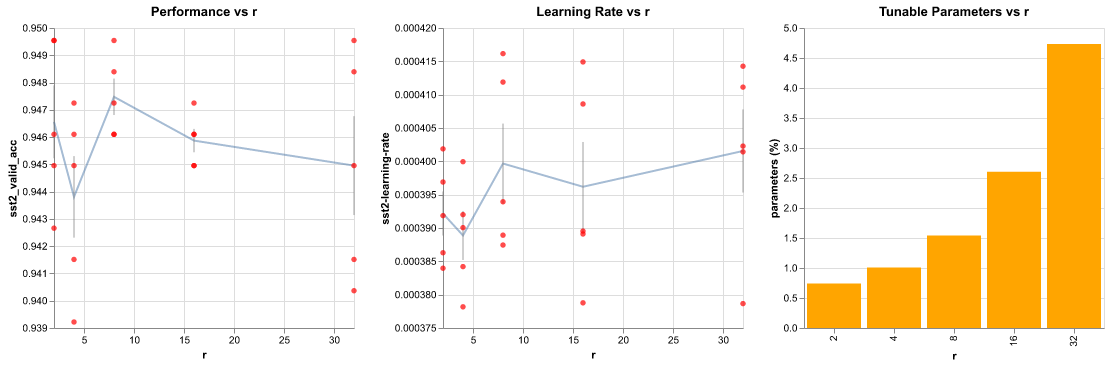

In [36]:
graphs = []
for field, title in [('sst2_valid_acc', 'Performance vs r'), ('sst2-learning-rate', 'Learning Rate vs r')]:
    summary = alt.Chart(topk_df, title=title).mark_line(opacity=0.5).encode(
        x = alt.X('r:Q'),
        y = alt.Y(f'mean({field}):Q', scale=alt.Scale(zero=False))
    )
    std = summary.mark_errorbar(color='grey', opacity=0.75).encode(
        y = alt.Y(f'{field}:Q', scale=alt.Scale(zero=False))
    )
    individual_points = std.mark_circle(color='red')

    graphs.append(summary + std + individual_points)

learnable_chart = alt.Chart(learnable_df, title='Tunable Parameters vs r', width=300).mark_bar(color='orange').encode(
    x = alt.X('r:O'),
    y = alt.Y('relative_percent:Q', title='parameters (%)')
)
    
alt.hconcat(*graphs, learnable_chart)

### Verify Reproducability

Let's pick a winning combination of hyperparameters and then validate that we weren't just lucky, but can repreatably produce sufficient results with those hyperparameter values.

It's up to us how small the adapters should become versus the performance we want to achieve. We have seen that we can roughly match the performance of the full-finetuning. In our case we needed a little bit more than one percent of the original parameters. With a larger model and exploiting the Intrinsic Dimension (see the first article) we would expect the percentage to go down a bit.

We will pick simple scenarios:
- All: We train adapters for all components on all laters with `r=8`.
- FF Up: We tune one adapter for each positionwise feed forward up projection with `r=16`, 12 in total, as we have 12 layers.

## Show comparisons with baseline here?

In [31]:
import concurrent.futures
import time

import traceback
import sys

# (r, conf)
combinations = [
    ( 2, 'all'),
    ( 8, 'all'),
    (16, 'all'),
    ( 4, 'ff_u'),
    ( 8, 'ff_u'),
    ( 8, 'ff_d'),
    (16, 'ff_u'),
    ( 8, 'att_v+ff_u'),
    ( 8, '12_lowest2_att_v_ff_u_ff_d'),
    ( 8, '12_top2_att_v_ff_u_ff_d'),
]

def do_capture(r, conf):
    title = f'LoRA {conf}, r={r}'
    print(f'Submitting {title}')
    est = PyTorch(**get_default_estimator_parameters())
    est.set_hyperparameters(**{'sst2-lora-r': r, 'sst2-lora-config': conf, **best_hyperparameters})
    try:
        capture_results(title, est, job_name=f'{r}-{conf.replace("_", "-").replace("+", "-")}')
    except Exception: 
        print(traceback.format_exc())

executor = concurrent.futures.ThreadPoolExecutor(max_workers=5)
futures = [executor.submit(do_capture, *args) for args in combinations]

print('Waiting ...')
concurrent.futures.wait(futures)

Submitting LoRA all, r=2
Submitting LoRA all, r=8
Submitting LoRA all, r=16
Submitting LoRA ff_u, r=4
Submitting LoRA ff_u, r=8
Waiting ...
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

dummy                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
2    0.0  8-ff-u-230811-1656-001-bf1ce9a0         Completed 2023-08-11 16:58:13+02:00 2023-08-11 17:12:52+02:00                       879.0  8-ff-u-230811-1656        0.943807
1    1.0  8-ff-u-230811-1656-002-ecd9fc1c         Completed 2023-08-11 16:59:16+02:00 2023-08-11 17:11:19+02:00                       723.0  8-ff-u-230811-1656        0.930046
0    3.0  8-ff-u-230811-1656-003-2acccfae         Completed 2023-08-11 16:58:14+02:00 2023-08-11 17:10:13+02:00                       719.0  8-ff-u-230811-1656        0.926606

Cache Hit/Miss: MM.M..
Submitting LoRA ff_d, r=8
.Using provided s3_resource
..........................!
.Tuning job 4-ff-u-230811-1656        status: Completed
.
Number of training jobs with valid objective: 3
Lowest: 0.9369266033172607 Highest 0.9392201900482178


dummy                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
1    2.0  4-ff-u-230811-1656-002-2a0b79b0         Completed 2023-08-11 16:59:04+02:00 2023-08-11 17:13:50+02:00                       886.0  4-ff-u-230811-1656        0.939220
2    0.0  4-ff-u-230811-1656-001-67bb190f         Completed 2023-08-11 17:00:01+02:00 2023-08-11 17:13:59+02:00                       838.0  4-ff-u-230811-1656        0.939220
0    3.0  4-ff-u-230811-1656-003-e58720d4         Completed 2023-08-11 16:59:07+02:00 2023-08-11 17:14:07+02:00                       900.0  4-ff-u-230811-1656        0.936927

Cache Hit/Miss: MMM..
Submitting LoRA ff_u, r=16
..Using provided s3_resource
.........................................................................................................................................!
.Tuning job 8-all-230811-1656         status: Completed
.
Number of training jobs with valid objective: 3
Lowest: 0.9426605701446533 Highest 0.9483944773674011


dummy                 TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds      TuningJobName  sst2_valid_acc
1    2.0  8-all-230811-1656-002-0de93eef         Completed 2023-08-11 16:59:01+02:00 2023-08-11 17:16:06+02:00                      1025.0  8-all-230811-1656        0.948394
0    3.0  8-all-230811-1656-003-ca46b342         Completed 2023-08-11 16:58:23+02:00 2023-08-11 17:14:13+02:00                       950.0  8-all-230811-1656        0.944954
2    0.0  8-all-230811-1656-001-e0b36970         Completed 2023-08-11 16:58:16+02:00 2023-08-11 17:13:16+02:00                       900.0  8-all-230811-1656        0.942661

Cache Hit/Miss: M.M!
Tuning job 16-all-230811-1656        status: Completed
M
Number of training jobs with valid objective: 3
Lowest: 0.9449541568756104 Highest 0.9495412707328796


dummy                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
0    3.0  16-all-230811-1656-003-a173e458         Completed 2023-08-11 16:58:21+02:00 2023-08-11 17:15:36+02:00                      1035.0  16-all-230811-1656        0.949541
2    0.0  16-all-230811-1656-001-0705dbf1         Completed 2023-08-11 16:58:13+02:00 2023-08-11 17:15:32+02:00                      1039.0  16-all-230811-1656        0.949541
1    2.0  16-all-230811-1656-002-153b8de3         Completed 2023-08-11 16:58:35+02:00 2023-08-11 17:15:49+02:00                      1034.0  16-all-230811-1656        0.944954

Cache Hit/Miss: M
.Submitting LoRA att_v+ff_u, r=8
MM.Using provided s3_resource

Submitting LoRA 12_lowest2_att_v_ff_u_ff_d, r=8
.Using provided s3_resource
.........................................................................................................................................................................................................................!
.Tuning job 2-all-230811-1656         status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9380733966827393 Highest 0.9506880640983582


dummy                 TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds      TuningJobName  sst2_valid_acc
2    1.0  2-all-230811-1656-001-3197dc1f         Completed 2023-08-11 16:58:08+02:00 2023-08-11 17:18:49+02:00                      1241.0  2-all-230811-1656        0.950688
1    2.0  2-all-230811-1656-002-02088db9         Completed 2023-08-11 16:58:12+02:00 2023-08-11 17:15:17+02:00                      1025.0  2-all-230811-1656        0.942661
0    3.0  2-all-230811-1656-003-9c361c8b         Completed 2023-08-11 16:58:18+02:00 2023-08-11 17:15:28+02:00                      1030.0  2-all-230811-1656        0.938073

Cache Hit/Miss: M..MM.
.Submitting LoRA 12_top2_att_v_ff_u_ff_d, r=8
.Using provided s3_resource
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
..Tuning job 8-ff-d-230811-1714        status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9254587292671204 Highest 0.9369266033172607


dummy                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
0    3.0  8-ff-d-230811-1714-003-45ff7e6d         Completed 2023-08-11 17:16:12+02:00 2023-08-11 17:30:57+02:00                       885.0  8-ff-d-230811-1714        0.936927
2    0.0  8-ff-d-230811-1714-001-fdd50f6d         Completed 2023-08-11 17:16:13+02:00 2023-08-11 17:29:08+02:00                       775.0  8-ff-d-230811-1714        0.928899
1    2.0  8-ff-d-230811-1714-002-4ebc3fe9         Completed 2023-08-11 17:16:08+02:00 2023-08-11 17:27:57+02:00                       709.0  8-ff-d-230811-1714        0.925459

Cache Hit/Miss: M.MM.
..............!
Tuning job 8-12-lowest2-att-v-f-230811-1718 status: Completed
.
Number of training jobs with valid objective: 3
Lowest: 0.7878440618515015 Highest 0.8256880640983582


dummy                                TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                     TuningJobName  sst2_valid_acc
0    2.0  8-12-lowest2-att-v-f-230811-1718-003-b41f61be         Completed 2023-08-11 17:19:25+02:00 2023-08-11 17:31:19+02:00                       714.0  8-12-lowest2-att-v-f-230811-1718        0.825688
1    1.0  8-12-lowest2-att-v-f-230811-1718-002-469702cc         Completed 2023-08-11 17:19:18+02:00 2023-08-11 17:30:51+02:00                       693.0  8-12-lowest2-att-v-f-230811-1718        0.816514
2    0.0  8-12-lowest2-att-v-f-230811-1718-001-fafffe9d         Completed 2023-08-11 17:19:16+02:00 2023-08-11 17:30:04+02:00                       648.0  8-12-lowest2-att-v-f-230811-1718        0.787844

Cache Hit/Miss: M..MM
...!
Tuning job 16-ff-u-230811-1715       status: Completed
..
Number of training jobs with valid objective: 3
Lowest: 0.9346330165863037 Highest 0.9449541568756104


dummy                   TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds        TuningJobName  sst2_valid_acc
2    0.0  16-ff-u-230811-1715-001-f4ecd91f         Completed 2023-08-11 17:16:47+02:00 2023-08-11 17:31:56+02:00                       909.0  16-ff-u-230811-1715        0.944954
1    1.0  16-ff-u-230811-1715-002-8be7695d         Completed 2023-08-11 17:16:56+02:00 2023-08-11 17:31:55+02:00                       899.0  16-ff-u-230811-1715        0.943807
0    3.0  16-ff-u-230811-1715-003-b461da9d         Completed 2023-08-11 17:16:51+02:00 2023-08-11 17:28:44+02:00                       713.0  16-ff-u-230811-1715        0.934633

Cache Hit/Miss: MMM
.........................................................!
Tuning job 8-att-v-ff-u-230811-1717  status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9438073635101318 Highest 0.9541284441947937


dummy                        TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds             TuningJobName  sst2_valid_acc
2    0.0  8-att-v-ff-u-230811-1717-001-47dff3b0         Completed 2023-08-11 17:19:16+02:00 2023-08-11 17:34:41+02:00                       925.0  8-att-v-ff-u-230811-1717        0.954128
0    2.0  8-att-v-ff-u-230811-1717-003-b849a98e         Completed 2023-08-11 17:19:20+02:00 2023-08-11 17:34:44+02:00                       924.0  8-att-v-ff-u-230811-1717        0.949541
1    1.0  8-att-v-ff-u-230811-1717-002-b1b7cff2         Completed 2023-08-11 17:19:14+02:00 2023-08-11 17:34:38+02:00                       924.0  8-att-v-ff-u-230811-1717        0.943807

Cache Hit/Miss: MMM
.............!
Tuning job 8-12-top2-att-v-ff-u-230811-1721 status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.7706422209739685 Highest 0.8279816508293152


dummy                                TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                     TuningJobName  sst2_valid_acc
2    0.0  8-12-top2-att-v-ff-u-230811-1721-001-d0373821         Completed 2023-08-11 17:23:12+02:00 2023-08-11 17:34:55+02:00                       703.0  8-12-top2-att-v-ff-u-230811-1721        0.827982
1    2.0  8-12-top2-att-v-ff-u-230811-1721-002-dbdd69e7         Completed 2023-08-11 17:23:16+02:00 2023-08-11 17:35:00+02:00                       704.0  8-12-top2-att-v-ff-u-230811-1721        0.822248
0    3.0  8-12-top2-att-v-ff-u-230811-1721-003-535d40b4         Completed 2023-08-11 17:23:12+02:00 2023-08-11 17:34:06+02:00                       654.0  8-12-top2-att-v-ff-u-230811-1721        0.770642

Cache Hit/Miss: MMM


DoneAndNotDoneFutures(done={<Future at 0x2d4007a00 state=finished returned NoneType>, <Future at 0x2d3f7cc10 state=finished returned NoneType>, <Future at 0x2ce33ae00 state=finished returned NoneType>, <Future at 0x2d3e0a230 state=finished returned NoneType>, <Future at 0x2ce33ba30 state=finished returned NoneType>, <Future at 0x2d3f8a290 state=finished returned NoneType>, <Future at 0x2ce33b6d0 state=finished returned NoneType>, <Future at 0x2ce33bf40 state=finished returned NoneType>, <Future at 0x2ce33bb50 state=finished returned NoneType>, <Future at 0x2d3f8a170 state=finished returned NoneType>}, not_done=set())

target_tuner_name                                 title  objective_metric_mean  objective_metric_std  parameters_relative  train_speed_median  gpu_memory_max
0                capture-230810-2012                       Full Finetuning               0.946865              0.008683           100.000000            1841.949            79.4
1                capture-230810-2030                       Classifier Only               0.827217              0.003504             0.475045           11877.474            13.3
2                capture-230810-2042                             LoRA Base               0.942661              0.002294             1.539733            1937.174            82.9
3                capture-230810-2100                            LoRA Paper               0.939602              0.002387             0.711642            3610.229            24.0
4                 8-ff-u-230811-1656                        LoRA ff_u, r=8               0.933486              0.009102             0.770792            5511.946            66.9
5                 4-ff-u-230811-1656                        LoRA ff_u, r=4               0.938456              0.001324             0.622918            2756.725            66.9
6                  8-all-230811-1656                         LoRA all, r=8               0.945336              0.002886             1.539733            1940.418            82.9
7                 16-all-230811-1656                        LoRA all, r=16               0.948012              0.002648             2.604422            1547.227            83.2
8                  2-all-230811-1656                         LoRA all, r=2               0.943807              0.006385             0.741217            1547.152            82.8
9                 8-ff-d-230811-1714                        LoRA ff_d, r=8               0.930428              0.005885             0.770792            3701.752            95.0
10  8-12-lowest2-att-v-f-230811-1718  LoRA 12_lowest2_att_v_ff_u_ff_d, r=8               0.810015              0.019741             0.475045            6012.743            13.3
11               16-ff-u-230811-1715                       LoRA ff_u, r=16               0.941132              0.005657             1.066538            2207.763            66.9
12          8-att-v-ff-u-230811-1717                  LoRA att_v+ff_u, r=8               0.949159              0.005171             0.889090            2032.433            72.0
13  8-12-top2-att-v-ff-u-230811-1721     LoRA 12_top2_att_v_ff_u_ff_d, r=8               0.806957              0.031580             0.475045            6029.236            13.3

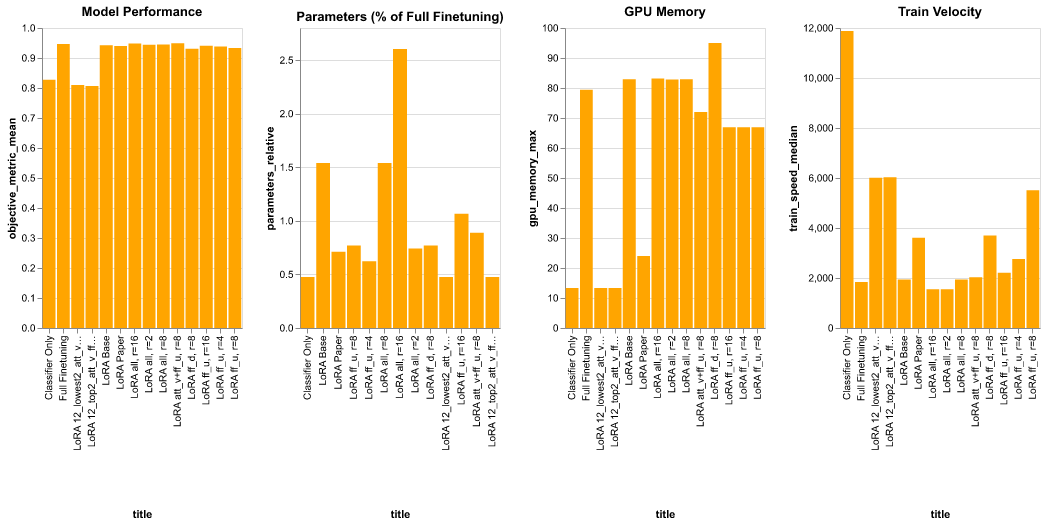

In [35]:
graph_results()

## Not considered

Given all the combinations possible there are many angles we could have pursuit, but limited ourselves to a smaller scope to keep things manageable and understandable. Amongst the angles not evaluated one stands out worth considering in the future: **Per-Adapter-R**. 

We see that on one hand the position-wise feed forward linear modules (`ff_up`, `ff_down` above) have more capacity than the linear modules used in attention. Assuming that they have been sized properly during pre-training, their larger capacity could also mean for fine-tuning that they can carry more information. It could be sensible then to use a higher rank than for the attention linear modules. On the other hand it could be that the specific finetuning task at hand is different enough from pre-training, that the original sizing is not appropriate and, here again, you can pick a specific r for specific modules, say the query linear modules that are close to the task head.
